## Options Liquidity


This notebook looks at how options LPs fare in various scenarios:

- hedged/unhedged
- whether they're the first LP in a market or a marginal LP who deposits a small amount when prices are already efficient
- whether range of strikes is wide or narrow

In [1]:
# most of the logic is in options.py
from options import *

# set params - these don't really matter that much
b = 100
initial_price = 2000

# we consider two ranges of strikes. wide strikes is what's live now for June options.
wide_strikes = [480, 600, 960, 1280, 1600, 1920, 2560, 3200, 3840, 5000, 6000, 8000, 10000]
narrow_strikes = [2000, 2250, 2500, 2570, 3000, 3250, 3500, 3750, 4000]


def plot_lp_return(hedge, lp_type, strike_prices):
    x = np.linspace(200, 20000, num=20)
    lp_payoff = np.array([calc_call_lp_payoff(px, strike_prices, b) for px in x])
    hedge_payoff = np.array([(hedge * b * calc_call_payoffs(px, strike_prices)).sum() for px in x])
    
    if lp_type == "marginal":
        q0 = calc_q(calc_call_payoffs(initial_price, strike_prices), b)
        lp_cost = db(q0, b) * b
        hedge_cost = (gradq(q0, b) * hedge * b).sum()
        cost = lp_cost + hedge_cost
    
    elif lp_type == "seed":
        cost = lmsr(hedge * b, b)
    
    else:
        raise ValueError()
    
    lp_return = (lp_payoff + hedge_payoff) / cost
    lp_return_percent = lp_return * 100 - 100

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    format_ax(ax)
    ax.set_ylabel("Return")
    ax.set_xlabel("Underlying price at expiry")
    ax.plot(x, lp_return_percent)

## Plots

### Unhedged seed LP

**Seed LPs** are the first LPs to deposit into a new market, before any trades or deposits have taken place

Plot below demonstrates seed LPs tend to lose at least 10% regardless of price. If price moves either way, they'll lose a lot more. This isn't great, but we show a way to reduce this loss later on.

Return is in terms of the underlying asset and assumes a single deposit is made when the market is first created and that the deposit is held until expiration. Doesn't include trading fees earned.

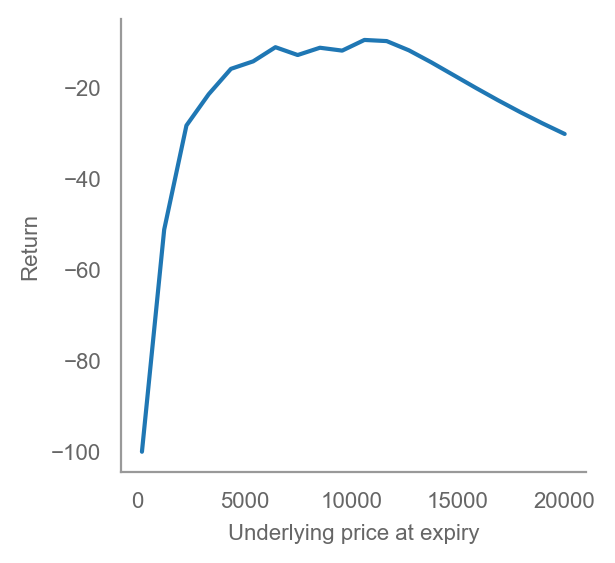

In [2]:
hedge = np.zeros(len(wide_strikes) + 1)
plot_lp_return(hedge, "seed", wide_strikes)

### Hedged seed LP

It's possible to approximately hedge this exposure (not possible to perfectly hedge). 2.5 calls with the lowest strike are sold and 1 call with the highest strike are bought for each LP share.

However, even if seed LP hedges, they'll still lose around 20-30%.

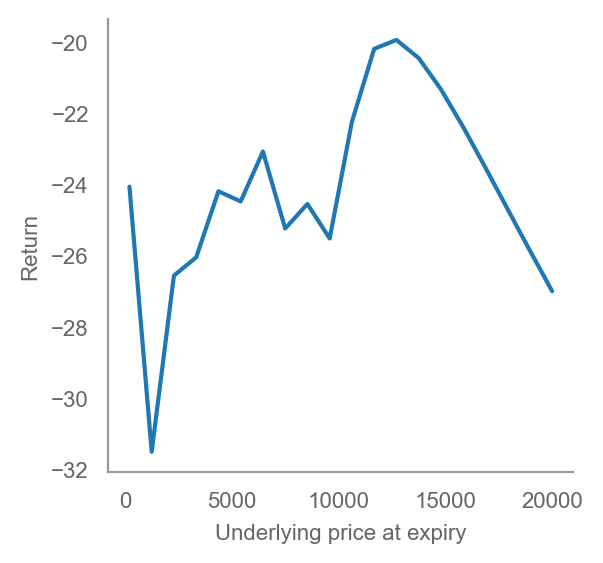

In [3]:
hedge = np.zeros(len(wide_strikes) + 1)
hedge[0] = 2.5
hedge[-1] = 1
plot_lp_return(hedge, "seed", wide_strikes)

### Hedged seed LP with narrow strike range
If the range of strikes offered by the market is narrowed, the loss is significantly reduced to around 5 - 15%.

The strikes now range from 2k - 4k instead of 480 - 10k, which is the current range for June options.

So with narrow strikes, a seed LP might make a profit but this depends on how much trading fees are earned.

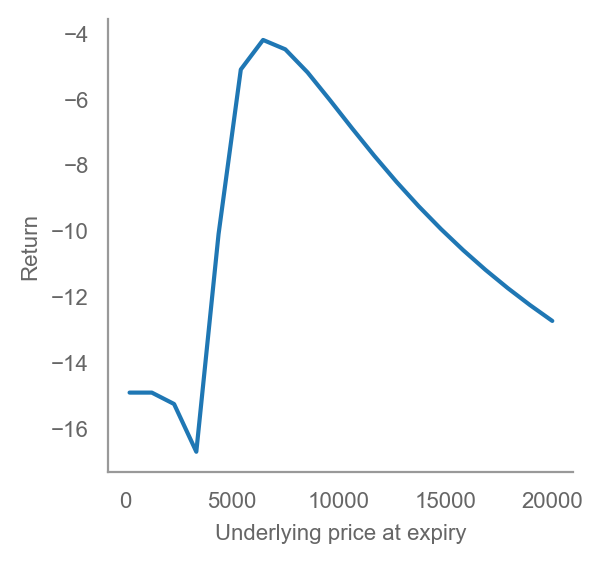

In [4]:
hedge = np.zeros(len(narrow_strikes) + 1)
hedge[0] = 3.5
hedge[-1] = 3
plot_lp_return(hedge, "seed", narrow_strikes)

### Unhedged marginal LP

Now let's look at **marginal LPs** - they tend to do way better.

Marginal LPs are LPs who deposit later on when the market is already in equilibrium - i.e. when prices are all efficient and where they should be (unlike seed LPs who deposit at the start when all prices are 1/n). This also assumes they deposit a small amount and so do not suffer from slippage.

They lose if underlying moves a lot, but make a profit for a wide range of prices.

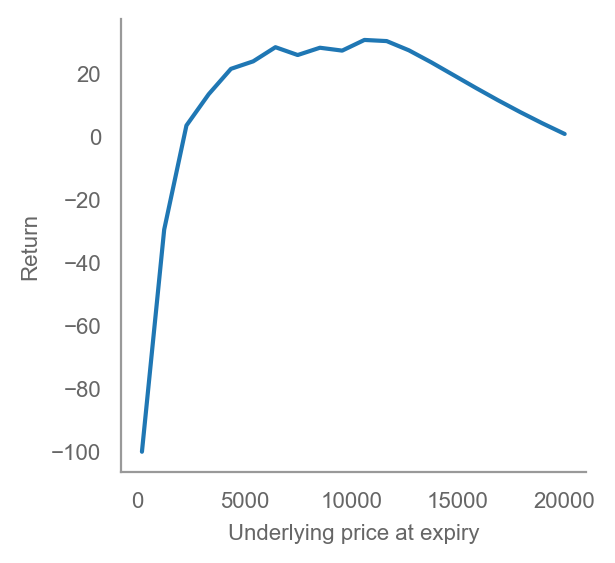

In [5]:
hedge = np.zeros(len(wide_strikes) + 1)
plot_lp_return(hedge, "marginal", wide_strikes)

### Hedged marginal LP

If a marginal LP hedges, it looks like they can do fine. Their pnl ranges from -6% to 8%, so if there's good volume they can probably make a profit taking fees into account. This is really encouraging because it indicates being an LP can be sustainable and profitable.

So this means the LP vault should always wait until prices become efficient before making further deposits.

When a market is created, the LP vault can only deposit a small amount (since seed liquidity has worse performance). It should wait until prices are efficient before depositing a bit more, and repeat this, gradually dripping in deposits.


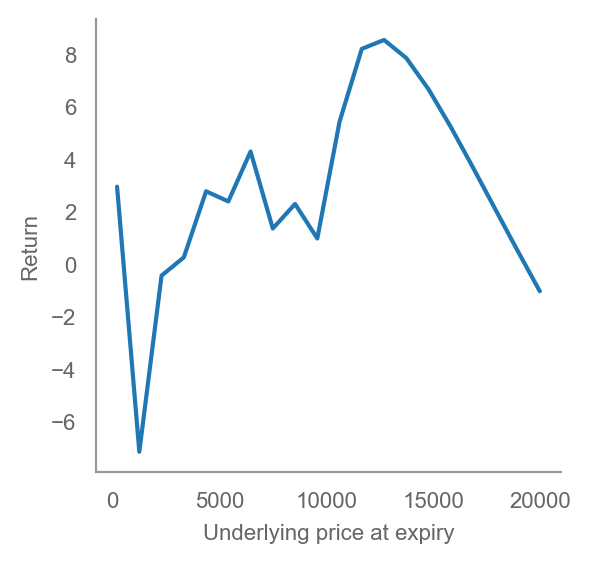

In [6]:
hedge = np.zeros(len(wide_strikes) + 1)
hedge[0] = 2.5
hedge[-1] = 1
plot_lp_return(hedge, "marginal", wide_strikes)

## Conclusion

The initial LPs in a new market tend to suffer losses. Later LPs tend to do well (assuming they deposit small amounts and only when prices are efficient).

So an LP vault should only deposit a small amount when a new market is created, then gradually drip in liquidity. It can probably be sustainable and profitable if it does this.

The strike prices for each market should be chosen in a narrow range, such as only 2k - 4k strikes for ETH. This will reduce the loss for the initial LPs and it means a market can safely build up liquidity faster.